# Paramaterial Usage Example

Importing the paramaterial module

In [1]:
import pandas as pd
# import paramaterial as a module
import paramaterial as pam

# check the version of paramaterial
print(pam.__version__)

0.0.11


Load the raw data and metadata into a DataSet object

In [2]:
# load the metadata spreadsheet and data files into a DataSet object
prepared_ds = pam.DataSet('info/01 prepared info.xlsx', 'data/01 prepared data')

# check the formatting of the loaded data and metadata
pam.check_formatting(prepared_ds)

Checking column headers...
First file headers:
	['Strain', 'Stress_MPa']
Headers in all files are the same as in the first file, except for None.
Checking for duplicate files...
No duplicate files found in "data/01 prepared data".


Sort and Get the metadata as a pandas DataFrame

In [3]:
# sort the dataitems in the dataset
prepared_ds = prepared_ds.sort_by(['temperature', 'lot'])

# get the metadata as a table
# prepared_ds.info_table

Use the subset method to get a subset of the data

In [4]:
# get a subset of only the tensile tests
prepared_ds = prepared_ds.subset({'test_type': ['T']})

Make an experimental matrix showing the distribution of the data

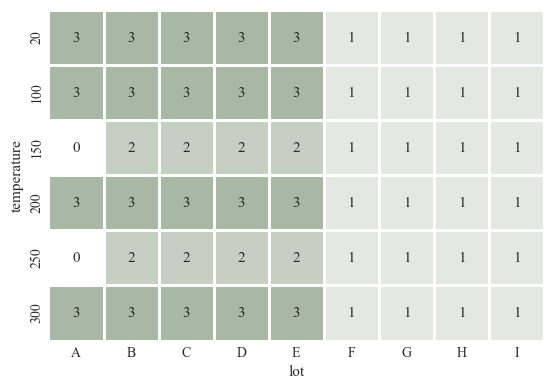

In [5]:
import matplotlib as mpl
cmap_green = mpl.colors.LinearSegmentedColormap.from_list("", ["white", (0.2124, 0.3495, 0.1692)])

# make a heatmap showing the distribution across lot and temperature
pam.experimental_matrix(info_table=prepared_ds.info_table, index='temperature', vmax=7,
                        columns='lot', as_heatmap=True, cmap=cmap_green);

Use a Styler object to format the plotting to the entire dataset

In [6]:
# instantiate a Styler object and format to match the prepared data
styler = pam.Styler(color_by='temperature', color_by_label='(°C)', cmap='plasma')
styler.style_to(prepared_ds)

# keys labels for stress-strain data plotting
labels_dict = dict(x='Strain', y='Stress_MPa', ylabel='Stress (MPa)')

Setup the dataset plot for a single plot of all the data

In [7]:
# define a function to plot the dataset
def ds_plot(ds, **kwargs):
    """Takes in a DataSet and extra plotting kwargs, returns a matplotlib Axes object."""
    return pam.dataset_plot(ds=ds, styler=styler, **labels_dict, **kwargs)


# plot the dataset
# ds_plot(prepared_ds);

Setup the dataset plot for a grid of plots of the data.

In [8]:
# define a function to plot the dataset as a grid of plots
def ds_subplots(ds, **kwargs):
    """Takes in a DataSet and extra plotting kwargs, returns an array of matplotlib Axes objects."""
    return pam.dataset_subplots(
        ds=ds, shape=(6, 5), styler=styler,
        rows_by='temperature', row_vals=[[20], [100], [150], [200], [250], [300]],
        cols_by='lot', col_vals=[['A'], ['B'], ['C'], ['D'], ['E']],
        col_titles=[f'Lot {lot}' for lot in 'ABCDE'], **labels_dict, **kwargs)


# plot the dataset as a grid of plots
# ds_subplots(prepared_ds);

## Processing
Find UTS and fracture point.

In [9]:
# determine the ultimate tensile strength for each test
prepared_ds = pam.find_UTS(ds=prepared_ds, strain_key='Strain',
                           stress_key='Stress_MPa')

# determine the fracture point for each test
prepared_ds = pam.find_fracture_point(ds=prepared_ds, strain_key='Strain',
                                      stress_key='Stress_MPa')

Trimming.

In [10]:
# define a function to trim the data to a small strain range
def trim_to_small_strain(di):
    """Takes in a DataItem and returns a trimmed DataItem."""
    di.data = di.data[di.data['Strain'] < 0.01]
    return di


# apply the function to the dataset
trimmed_ds = prepared_ds.apply(trim_to_small_strain)

# plot the trimmed dataset
# ds_plot(trimmed_ds);

Apply foot correction.

In [11]:
# determine the upper and lower proportional limits for each test
trimmed_ds = pam.find_upl_and_lpl(ds=trimmed_ds, preload=36,
                                  preload_key='Stress_MPa')

# apply the foot correction to the dataset
corrected_ds = pam.correct_foot(ds=trimmed_ds, LPL_key='LPL', UPL_key='UPL')

# plot the corrected dataset
# ds_plot(corrected_ds);

Make screening pdf for foot correction screening.

In [12]:
# define a function to plot a single test for foot correction screening
def foot_correction_screening_plot(di):
    """Takes in a DataItem and returns a matplotlib Axes object."""
    color = styler.color_dict[di.info['temperature']]
    LPL = (di.info['UPL_0'], di.info['UPL_1'])
    UPL = (di.info['LPL_0'], di.info['LPL_1'])
    ax = ds_plot(corrected_ds.subset({'test_id': di.test_id}))
    ax = ds_plot(trimmed_ds.subset({'test_id': di.test_id}), alpha=0.5, ax=ax)
    ax.axline(UPL, slope=di.info['E'], c=color, ls='--', alpha=0.5)
    ax.plot(*UPL, c=color, marker=4)
    ax.plot(*LPL, c=color, marker=5)
    return ax


# make the screening pdf
# pam.make_screening_pdf(corrected_ds, plot_func=foot_correction_screening_plot,
#                        pdf_path='info/foot-correction screening.pdf')

Read screening pdf.

In [13]:
# read the annotated screening pdf fields to the dataset
corrected_ds = pam.read_screening_pdf(ds=corrected_ds,
                                      pdf_path='info/screening-marked.pdf')

# get the metadata table of the rejected items
# corrected_ds.info_table[corrected_ds.info_table['reject'] == 'True']

Remove the rejected items

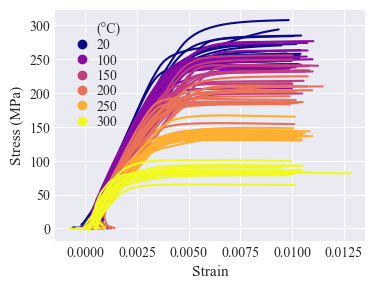

In [14]:
# remove the rejected tests from the dataset
screened_ds = pam.remove_rejected_items(ds=corrected_ds, reject_key='reject')

# plot the screened dataset
ds_plot(screened_ds);

Algorithmically find the proof stresses.

In [15]:
# find the 0.2% proof stress for each test
screened_ds = pam.find_proof_stress(ds=screened_ds, proof_strain=0.002, E_key='E',
                                    strain_key='Strain', stress_key='Stress_MPa')

Write processed data.

In [16]:
# write the metadata table data files to the specified paths
screened_ds.write_output('info/02 processed info.xlsx',
                         'data/02 processed data')

# load the processed dataset
processed_ds = pam.DataSet('info/02 processed info.xlsx',
                           'data/02 processed data')

# plot the processed dataset as a grid of plots
# ds_subplots(processed_ds);

## Data Aggregation

Generate representative curves.

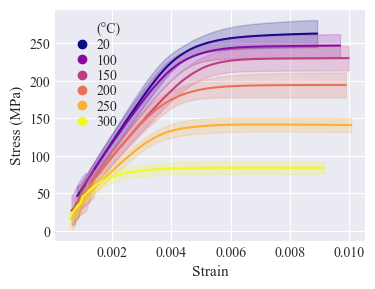

In [17]:
# make representative curves for each temperature and test type
pam.make_representative_data(
    ds=processed_ds, info_path='info/03 repres info.xlsx',
    data_dir='data/03 repres data', repres_col='Stress_MPa',
    interp_by='Strain', interp_range='inner',
    group_by_keys=['temperature', 'test_type'],
    group_info_cols=['UTS_0', 'UTS_1', 'FP_0', 'E',
                     'PS_0.002_0', 'PS_0.002_1', 'UPL_1'])

# load the representative dataset
repres_ds = pam.DataSet('info/03 repres info.xlsx',
                        'data/03 repres data',
                        test_id_key='repres_id')

# plot representative curves with standard deviation bands
ds_plot(repres_ds,
        fill_between=('down_std_Stress_MPa', 'up_std_Stress_MPa'));

# get the metadata table of the representative dataset
# repres_ds.info_table

Fit models.

In [18]:
# get the Ramberg-Osgood model function
ramberg_func = pam.models.ramberg

# set up the modelset, variables are known, params are unknown
ramberg_ms = pam.ModelSet(
    model_func=pam.models.ramberg,
    var_names=['E', 'UPL_1'],
    param_names=['H', 'n'],
    bounds=[(0., 1000.), (0.01, 0.8)]
)

# fit the modelset to the representative dataset
ramberg_ms.fit_to(repres_ds, x_key='Strain', y_key='Stress_MPa')

# get a table of the fitted parameters
# ramberg_ms.params_table

Predict data from fitted models.

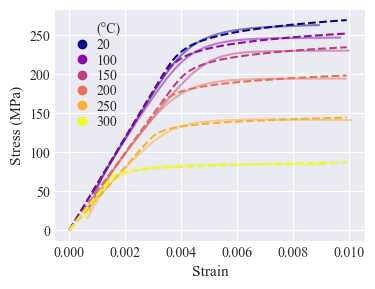

In [19]:
# Predict a dataset from the modelset
ramberg_ds = ramberg_ms.predict()

# Plot the fitted curves above the representative curves
ax = ds_plot(repres_ds, alpha=0.5)
ds_plot(ramberg_ds, ls='--', ax=ax);

## Quality Control


Check for outliers.

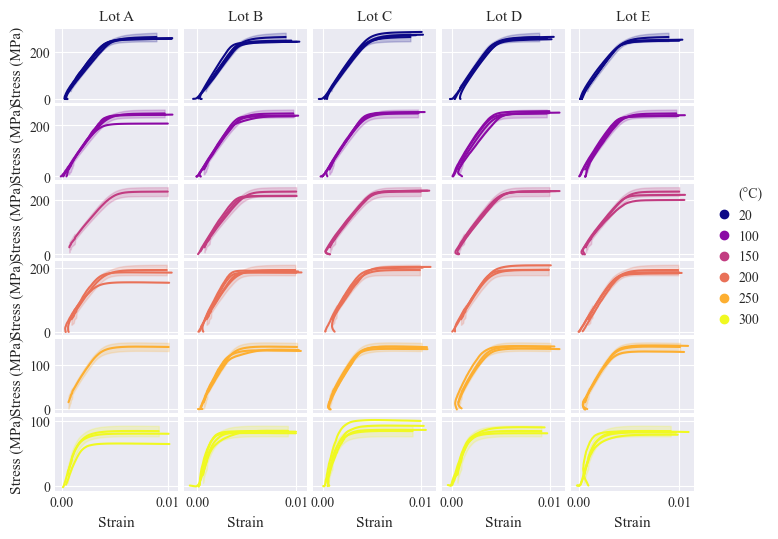

In [20]:
# Plot the processed curves on a grid of subplots
axs = ds_subplots(processed_ds)

# Plot the representative curve for a row on all the plots in that row
for i, temp in enumerate(processed_ds.info_table['temperature'].unique()):
    for j in range(axs.shape[1]):
        ax = axs[i, j]
        ds_plot(ds=repres_ds.subset({'temperature': temp}),
                ax=axs[i, j], plot_legend=False,
                fill_between=('up_std_Stress_MPa', 'down_std_Stress_MPa'))

Read placeholders from the test report template.

In [21]:
receipts = pam.TestReceipts(template_path=r'receipts_template.tex')
receipts.parse_placeholders(as_dict=True)

{'table_info': None, 'plot_raw': None, 'test_id': None, 'plot_processed': None}

Setup functions for the test reports.

In [22]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

def receipts_raw_plot(di):
    test_id = di.test_id
    color = styler.color_dict[di.info['temperature']]
    UTS = (di.info['UTS_0'], di.info['UTS_1'])
    ax = ds_plot(prepared_ds.subset({'test_id': test_id}), title=f'Raw Data')
    ax.plot(*UTS, color=color, marker='s', label='UTS')
    plot_name = f'{test_id} raw.pdf'
    handles = [mlines.Line2D([], [], color=color, marker='s', ls='None', label='UTS')]
    ax.legend(handles=handles, loc='best')
    plt.savefig(plot_name, bbox_inches='tight', dpi=150)
    return plot_name


def receipts_processed_plot(di):
    test_id = di.test_id
    color = styler.color_dict[di.info['temperature']]
    UPL = (di.info['UPL_0'], di.info['UPL_1'])
    LPL = (di.info['LPL_0'], di.info['LPL_1'])
    PS_0_002 = (di.info['PS_0.002_0'], di.info['PS_0.002_1'])
    ax = ds_plot(trimmed_ds.subset({'test_id': di.test_id}), alpha=0.5)
    ds_plot(corrected_ds.subset({'test_id': di.test_id}), ax=ax, title='Processed Data')
    ax.axline(UPL, slope=di.info['E'], c=color, ls='--', alpha=0.5)
    ax.axline(PS_0_002, slope=di.info['E'], c=color, ls='--', alpha=0.5)
    ax.plot(*UPL, c=color, marker=4)
    ax.plot(*LPL, c=color, marker=5)
    ax.plot(*PS_0_002, c=color, marker='*')
    handles = [mlines.Line2D([], [], color=color, marker=4, ls='None', label='UPL'),
               mlines.Line2D([], [], color=color, marker=5, ls='None', label='LPL'),
               mlines.Line2D([], [], color=color, marker='*', ls='None', label='PS_0.002')]
    plot_name = f'{test_id} processed.pdf'
    ax.legend(handles=handles, loc='best')
    plt.savefig(plot_name, bbox_inches='tight', dpi=150)
    return plot_name


def receipts_table(di):
    series = di.info
    for key in ['UTS_1', 'UPL_1', 'LPL_1', 'PS_0.002_1', 'E']:
        series[key] = round(series[key], 2)
    for key in ['UTS_0', 'UPL_0', 'LPL_0', 'PS_0.002_0', 'FP_0']:
        series[key] = round(series[key], 4)
    # series = series.style.to_latex(escape=False, header=False)
    # table_string = series.to_frame().style.format(escape='latex').to_latex()
    table_string = series.to_frame().style.to_latex()
    return table_string

Generate the test reports.

In [ ]:
# Define a dictionary of functions for replacing the placeholders
replace_dict = {'test_id': lambda di: di.test_id,
                'plot_raw': receipts_raw_plot,
                'plot_processed': receipts_processed_plot,
                'table_info': receipts_table}

# Generate the combined test receipts PDF
receipts.generate_receipts(ds=processed_ds,
                           receipts_path='info/test_receipts.pdf',
                           replace_dict=replace_dict);